
##0. GOAL
연주는 부쩍 헬스에 관심이 많이 생겼다고 합니다.
주변 헬스인들에게 이 사실을 알리니, 프로틴 보충제 사이트를 추천해주더군요.

며칠 전 텍스트 전처리를 배운 준석이는 해당 사이트에서 보충제 리뷰를 크롤링해와 워드클라우드를 그려보기로 결심합니다.

파이프라인은 다음과 같습니다.

 1. 정규표현식으로 한글만 추린다
 2. 띄어쓰기를 교정한다(PyKospacing)
 3. 형태소로 토큰화한다(okt)
 4. 불용어를 제거한다
 5. 원하는 단어를 Konlpy 사전에 추가한다
 6. 워드클라우드를 그린다


##1. import, load data

In [22]:
!pip install konlpy
!pip install git+https://github.com/haven-jeon/PyKoSpacing.git

  Cloning https://github.com/haven-jeon/PyKoSpacing.git to /tmp/pip-req-build-gs5qkzn6
  Running command git clone --filter=blob:none --quiet https://github.com/haven-jeon/PyKoSpacing.git /tmp/pip-req-build-gs5qkzn6
  Resolved https://github.com/haven-jeon/PyKoSpacing.git to commit b32a889cbd10b006d2f4aba118f0cd5b677e2979
  Preparing metadata (setup.py) ... done
  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [23]:
import pandas as pd
import numpy as np
import re
import pandas as pd

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
df = pd.read_csv("/content/drive/MyDrive/protein.csv")

In [26]:
df.head()

,Unnamed: 0,title,content,text
0,0,처음 사먹어 보는데 맛있네요,맛이 좋아서 꾸준히 먹고 있습니다.^^,처음 사먹어 보는데 맛있네요맛이 좋아서 꾸준히 먹고 있습니다.^^
1,1,말해 뭐합니까 ㅋㅋㅋ 역시,가성비 갑 제품 + 맛도 다양해서 ㅋㅋㅋ 항상 구매하고 있습니다요! \n\n ...,말해 뭐합니까 ㅋㅋㅋ 역시가성비 갑 제품 + 맛도 다양해서 ㅋㅋㅋ 항상 구매하고 있...
2,2,좋넹요,맛있습니다. 저번에 말차라떼도 먹어봤는데 그것보다 더 나은거 같네요,좋넹요맛있습니다. 저번에 말차라떼도 먹어봤는데 그것보다 더 나은거 같네요
3,3,매우 만족합니다,5키로는 정말 엄청크네요.\n 평점이 좋아서 스트로베리크림으로 주문했는데 좋습...,매우 만족합니다5키로는 정말 엄청크네요.\n 평점이 좋아서 스트로베리크림으로 ...
4,4,마싯어요,약간 달긴 하지만 물에 잘 녹고 가루날림이 거의없어 좋아요,마싯어요약간 달긴 하지만 물에 잘 녹고 가루날림이 거의없어 좋아요


## 2. 정규표현식으로 한글 단어만 남기기

이제 정규표현식으로 한글 단어만 남기고 모두 제외합니다.

In [27]:
def extract_hangul(text):
  hangul = re.sub('[^가-힣]', ' ', text)
  return hangul

In [28]:
example = extract_hangul(df['text'][1])
print("전처리 이전: ",df['text'][1])
print("전처리 이후: ",example)

전처리 이전:  말해 뭐합니까 ㅋㅋㅋ 역시가성비 갑 제품 + 맛도 다양해서 ㅋㅋㅋ 항상 구매하고 있습니다요! 

    스트로베리 크림치즈가 가장 맛있었네요!
전처리 이후:  말해 뭐합니까     역시가성비 갑 제품   맛도 다양해서     항상 구매하고 있습니다요        스트로베리 크림치즈가 가장 맛있었네요 


## 3. 띄어쓰기 교정(PyKoSpacing)

`PyKoSpacing`은 띄어쓰기가 되지 않은 문장을 띄어쓰기가 된 문장으로 교정해주는 패키지입니다다. 앞서 한글 외 다른 문자를 공백으로 치환했는데, 중첩된 공백들도 이 띄어쓰기 교정으로 하나의 공백으로 바꿔줄 수 있습니다.

In [29]:
from pykospacing import Spacing
spacing = Spacing()

In [30]:
def spacing_text(text):
  spaced_text = spacing(text)
  return spaced_text

In [31]:
spaced = spacing_text(example)
print("전처리 이전: ",example)
print("전처리 이후: ",spaced)

전처리 이전:  말해 뭐합니까     역시가성비 갑 제품   맛도 다양해서     항상 구매하고 있습니다요        스트로베리 크림치즈가 가장 맛있었네요 
전처리 이후:  말해 뭐 합니까 역시 가성비 갑 제품 맛도 다양해서 항상 구매하고 있습니다 요 스트로베리 크림치즈가 가장 맛있었네요


## 4. 형태소 분석기(okt)

한국어에서 토큰화를 해주는 대표적인 도구는 `konlpy`입니다. 가장 대표적인 형태소 분석기는 `Okt` 모델입니다.

In [32]:
from konlpy.tag import Okt
okt = Okt()

In [33]:
def extract_morphs(text):
  morphs_ = okt.morphs(text, stem=True)
  return morphs_

In [34]:
morphs_ = extract_morphs(spaced)
print("전처리 이전: ",spaced)
print("전처리 이후: ",morphs_)

전처리 이전:  말해 뭐 합니까 역시 가성비 갑 제품 맛도 다양해서 항상 구매하고 있습니다 요 스트로베리 크림치즈가 가장 맛있었네요
전처리 이후:  ['말', '하다', '뭐', '합', '니까', '역시', '가성비', '갑', '제품', '맛', '도', '다양하다', '항상', '구매', '하고', '있다', '요', '스트로베리', '크림', '치즈', '가', '가장', '맛있다']


## 5. 불용어 제거

분석에 있어 큰 의미가 없는 '불용어(stopword)'를 지정해줘야 합니다. '하다', '도', '는', '이다' 등 의미가 없는 어미나 조사같은 것을 지워주기로 합니다.

불용어 참고 사이트: https://www.ranks.nl/stopwords/korean

위 불용어 자료에서 몇 개의 단어를 추가해서 저장해두었습니다.

In [35]:
with open('/content/drive/MyDrive/stopword.txt') as f:
    list_file = f.readlines()

stopwords_list = []
for stopword in list_file:
  stopwords = re.sub('[\n]', '', stopword)
  stopwords_list.append(stopwords)

def remove_stopwords(text):
  remove_stop = [x for x in text if x not in stopwords_list]
  return remove_stop

In [36]:
remove_stop = remove_stopwords(morphs_)
print("전처리 이전: ",morphs_)
print("전처리 이후: ",remove_stop)

전처리 이전:  ['말', '하다', '뭐', '합', '니까', '역시', '가성비', '갑', '제품', '맛', '도', '다양하다', '항상', '구매', '하고', '있다', '요', '스트로베리', '크림', '치즈', '가', '가장', '맛있다']
전처리 이후:  ['말', '뭐', '합', '니까', '역시', '가성비', '갑', '제품', '맛', '도', '다양하다', '항상', '구매', '하고', '요', '스트로베리', '크림', '치즈', '가장', '맛있다']


추가적으로, 불용어로만 걸러내기엔 한계가 있고 아예 한 글자 단어들을 전부 없애주는 것이 나은 경우가 있습니다. 하지만, '맛', '향', '짱'과 같은 핵심적인 단어들은 남겨두기로 했다.

In [37]:
def remove_one(text):
  except_list = ['맛','향','짱']
  remove_one_ = [x for x in text if len(x)>1 or x in except_list]
  return remove_one_

In [38]:
remove_one_ = remove_one(remove_stop)
print("전처리 이전: ",remove_stop)
print("전처리 이후: ",remove_one_)

전처리 이전:  ['말', '뭐', '합', '니까', '역시', '가성비', '갑', '제품', '맛', '도', '다양하다', '항상', '구매', '하고', '요', '스트로베리', '크림', '치즈', '가장', '맛있다']
전처리 이후:  ['니까', '역시', '가성비', '제품', '맛', '다양하다', '항상', '구매', '하고', '스트로베리', '크림', '치즈', '가장', '맛있다']


그런데 몇 단어들을 찾아보니 `가성비`는 `가`, `성비`가 나뉘고 `프로틴`은 `프로`, `틴`이 나뉘는 안타까운 상황이 발생했습니다.

이런 경우, konlpy 사전에 직접 단어를 등재시키는 방법이 있습니다.

아래처럼 `os` 모듈을 사용하여 코랩 패키지에 저장된 konlpy 폴더에 손을 대는 방식입니다.

우선 `chdir`로 경로를 이동해주고 `makedirs`로 임시폴더를 만들어준 후. 이 임시폴더에서 단어 사전을 수정한 뒤 원본 폴더에 저장해줍니다.

** FileNotFoundError가 발생하는 경우 아래 directory에서 python 버전이 잘못된 경우일 수 있습니다.

In [39]:
import sys
print(sys.version)

3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


In [40]:
import os

os.chdir('/usr/local/lib/python3.12/dist-packages/konlpy/java')
os.getcwd()
os.makedirs('./aaaa', exist_ok=True)

In [41]:
os.chdir('/usr/local/lib/python3.12/dist-packages/konlpy/java/aaaa') #임시 폴더로 이동
os.getcwd()

'/usr/local/lib/python3.12/dist-packages/konlpy/java/aaaa'

임시폴더에 konlpy 사전 파일의 압축을 풀어줍니다.

In [42]:
!jar xvf ../open-korean-text-2.1.0.jar

  created: META-INF/
 inflated: META-INF/MANIFEST.MF
  created: META-INF/maven/
  created: META-INF/maven/org.openkoreantext/
  created: META-INF/maven/org.openkoreantext/open-korean-text/
 inflated: META-INF/maven/org.openkoreantext/open-korean-text/pom.properties
 inflated: META-INF/maven/org.openkoreantext/open-korean-text/pom.xml
  created: org/
  created: org/openkoreantext/
  created: org/openkoreantext/processor/
 inflated: org/openkoreantext/processor/KoreanPosJava.class
 inflated: org/openkoreantext/processor/KoreanTokenJava.class
 inflated: org/openkoreantext/processor/OpenKoreanTextProcessor$.class
 inflated: org/openkoreantext/processor/OpenKoreanTextProcessor.class
 inflated: org/openkoreantext/processor/OpenKoreanTextProcessorJava.class
  created: org/openkoreantext/processor/normalizer/
 inflated: org/openkoreantext/processor/normalizer/KoreanNormalizer$.class
 inflated: org/openkoreantext/processor/normalizer/KoreanNormalizer$Segment$.class
 inflated: org/openkoreantext

압축이 잘 풀렸으니 이제 명사들이 등재되어 있는 names.txt를 열어봅니다.

In [43]:
with open(f"/usr/local/lib/python3.12/dist-packages/konlpy/java/aaaa/org/openkoreantext/processor/util/noun/names.txt") as f:
    data = f.read()

아래처럼 다양한 단어들이 저장되어있는 것을 볼 수 있다. 여러 사용자들의 니즈를 반영하여 몇 단어들이 추가된 것으로 보입니다.

In [44]:
data

'가몽\n가온\n갓세븐\n강새이\n게임닉가\n관우\n귀여미\n규\n김유이\n김준면\n까까런\n노컷\n누너예\n니노\n다마고치\n다이무스\n대학생\n데이브\n도요토미\n동운\n동이\n두주니\n디시인사이드\n디오\n라몹\n라스\n라옵\n멍구\n메이든\n명덕\n명량\n문민정부\n미네\n방엘리\n병헌\n붓다\n비정상회담\n빼빼로\n삼풍\n샤인온미\n성식\n성열\n세라문\n세라복\n세종대왕\n손권\n손책\n쇼미더머니\n쇼챔\n순규\n스라소니\n신동아\n신쓰패밀리\n신아라\n아베\n안상홍\n안홍준\n여누\n여랑\n여포\n연합\n오꾸닭\n요섭\n웃찾사\n원식\n유병언\n유비\n유이\n윤기형\n이나단\n이명박\n이완용\n임창용\n자괴\n자니윤\n자대련\n자유\n재중이\n전교조\n정윤회\n제갈량\n조자룡\n조조\n준면\n지오디\n지존파\n진영오\n차작가\n차트\n창섭\n챠트\n첸\n코르사주\n하무열\n하용파쿠\n혁재\n현이\n현태\n혜미\n프로틴\n가성비\n밀크티\n'

일단 세 개의 단어를 추가해보도록 합시다. 그리고 쓰기 모드로 변경하여 새롭게 파일을 저장합니다.

예시로는 아래 세 가지 단어를 넣었지만, 여러분께서 마음껏 원하는 단어를 넣어보셔도 좋습니다.

In [45]:
data += '프로틴\n가성비\n밀크티\n'

with open("/usr/local/lib/python3.12/dist-packages/konlpy/java/aaaa/org/openkoreantext/processor/util/noun/names.txt", 'w') as f:
    f.write(data)

이제 다시 파일을 압축시키면 완료! 런타임을 재실행해야 제대로 반영이 됩니다.

1. 메뉴 바에서 **런타임** 클릭
2. 드롭다운 메뉴에서 **세션 다시 시작**을 선택

In [46]:
!jar cvf ../open-korean-text-2.1.0.jar *

added manifest
ignoring entry META-INF/
ignoring entry META-INF/MANIFEST.MF
adding: META-INF/maven/(in = 0) (out= 0)(stored 0%)
adding: META-INF/maven/org.openkoreantext/(in = 0) (out= 0)(stored 0%)
adding: META-INF/maven/org.openkoreantext/open-korean-text/(in = 0) (out= 0)(stored 0%)
adding: META-INF/maven/org.openkoreantext/open-korean-text/pom.properties(in = 119) (out= 110)(deflated 7%)
adding: META-INF/maven/org.openkoreantext/open-korean-text/pom.xml(in = 9127) (out= 2208)(deflated 75%)
adding: org/(in = 0) (out= 0)(stored 0%)
adding: org/openkoreantext/(in = 0) (out= 0)(stored 0%)
adding: org/openkoreantext/processor/(in = 0) (out= 0)(stored 0%)
adding: org/openkoreantext/processor/KoreanPosJava.class(in = 2457) (out= 1241)(deflated 49%)
adding: org/openkoreantext/processor/KoreanTokenJava.class(in = 1976) (out= 931)(deflated 52%)
adding: org/openkoreantext/processor/OpenKoreanTextProcessor$.class(in = 7716) (out= 2400)(deflated 68%)
adding: org/openkoreantext/processor/OpenKor

원래 두 단어로 나뉘어서 나오던 것들이 올바르게 한 단어로 출력되는 것을 볼 수 있습니다.

In [47]:
print(okt.nouns("가성비"))
print(okt.nouns("프로틴"))

['가성비']
['프로틴']


전 과정을 하나로 통합하면 아래와 같습니다.

In [48]:
from konlpy.tag import Okt
okt = Okt()

from pykospacing import Spacing
spacing = Spacing()

except_list = ['맛','향','짱']

with open('/content/drive/MyDrive/stopword.txt') as f:
    list_file = f.readlines()

stopwords_list = []
for stopword in list_file:
  stopwords = re.sub('[\n]', '', stopword)
  stopwords_list.append(stopwords)

def review_to_words(raw_review):
  text = re.sub('[^가-힣]', ' ', raw_review)
  text = spacing(text)
  text = okt.morphs(text, stem=True)
  text = [x for x in text if x not in stopwords_list]
  text = [x for x in text if len(x)>1 or x in except_list]
  text = " ".join(text)
  return text

이제 `words_list`를 만들어 전처리한 단어들을 하나의 리스트에 모아줍니다. 띄어쓰기 교정 과정에서 약간 지연됩니다.


In [49]:
import tqdm
df_len = df.shape[0]
words_list = []
for i in range(df_len):
  words_list.append(review_to_words(df['text'][i]))

In [50]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

%matplotlib inline
def displayWordCloud(data = None, backgroundcolor = 'white', width=None, height=None):
    wordcloud = WordCloud(font_path = '/content/drive/MyDrive/malgun.ttf',
                          background_color = backgroundcolor,
                          width = width,
                          height = height).generate(data)
    plt.figure(figsize = (15 , 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()


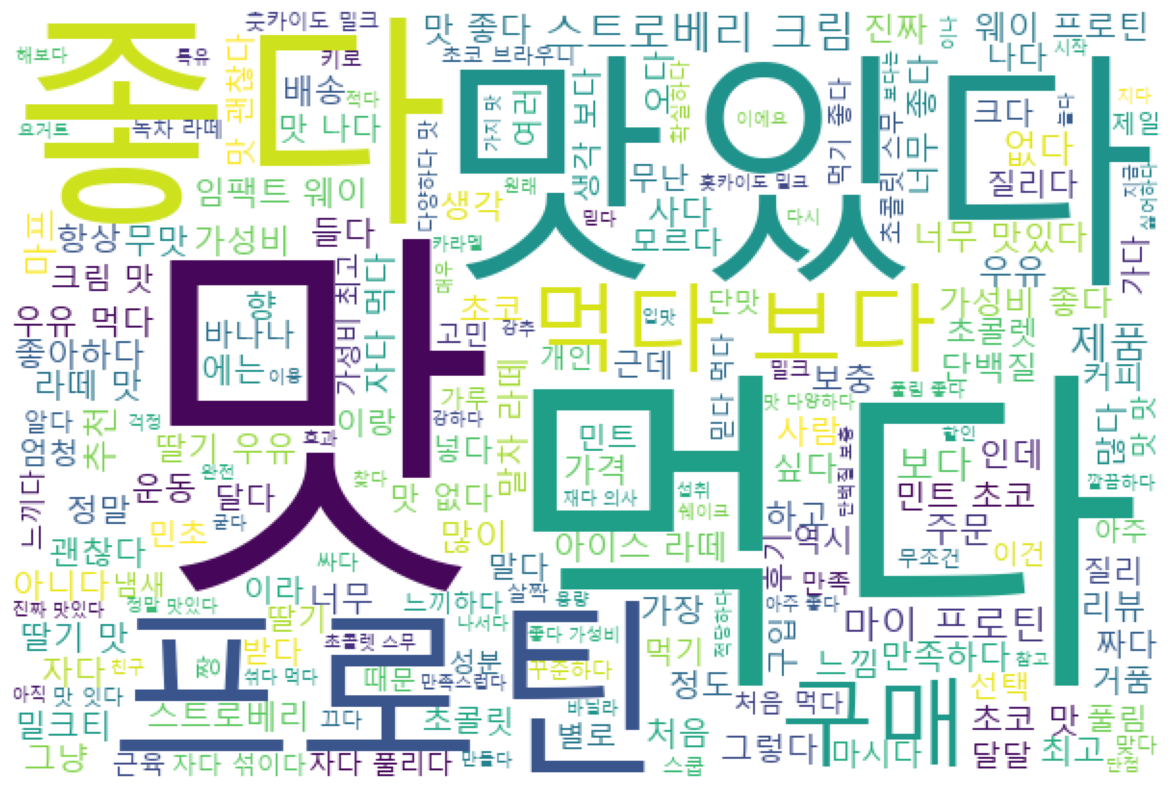

In [51]:
displayWordCloud(data = ' '.join(words_list), width=600, height=400)